# Analyse des anomalies dans les donnees du bitcoin en se basant sur les patterns

Citer l'article scientifique

### Introduction

Bla bla bla ...

Traduire et adapter ca :
In a closed economic system like blockchain, the total amount of generated cryp-
tocurrency called bitcoin is conserved and the transaction patterns demonstrate an
insight of money flow inside the blockchain. For the last 2 years, bitcoin market
has grabbed an immense attention from the investors, technology entrepreneurs
and currency enthusiasts. In this paper, we have come up with some findings in our
investigation about the bitcoin time-series transaction patterns. We have graphically
represented bitcoin’s weekly patterns as a real economic currency that has been
minted, stored and exchanged inside the bitcoin blockchain network. We identified
outliers’ activities with the help of descriptive statistical analysis. We also demon-
strated transaction pattern behavioral change. The main implication of these findings
is to understand some stylized facts of the time-series transaction of cryptocurrency-
based fully digital financial system. Besides in our analysis, we have shown that
the behavioral change of the transaction pattern is capable of explaining the system
development events or major historical events that have a network impact

This paper is basically focused on three aspects of blockchain-based open
source financial data. First of all, we re-structured blockchain’s already extracted
database (Kondor et al. 2014) for generating a hawk-eye view to observe bitcoin’s
daily transaction patterns to understand its economic growth with the course of
time. Secondly, we had done the descriptive analysis on that database of daily
transaction number and bitcoin volume to understand some of the most interest-
ing and informative statistical distribution. Finally, we had investigated the rank
distribution of some of the distinct transactions and their descriptive statistical
facts to extract some network topological features.

In [1]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Dataset

Expliquer la provenence des donnees (Défi EGC 2024: Jeu de données Bitcoin) -> https://github.com/Yquetzal/DefiEGC2024
Pas tres long car tout le mond esait d'ou elles viennent

Expliquer quelles donnees du dataset on va utiliser et pourquoi


In [2]:
# extracting data
global_data = pd.read_csv('egc2024/timeseries/global.csv')
# removing unecessary data
global_data = global_data.drop(['year',	'month', 'day'], axis=1)
global_data = global_data.rename(columns={ global_data.columns[0]: "date" })
global_data['date'] = pd.to_datetime(global_data['date'])
global_data

,date,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,nb_transactions,nb_payments,mean_nb_inputs,mean_nb_outputs,nb_mining,total_mining_satoshi,newly_created_coins,self_spent_satoshi,total_received,volume_without_self
0,2015-01-01,801373971,45473028339385,45058028339385,13609.829337,4.284054e+06,0.799999,58882,161194,2.595241,2.737577,166,415801373971,415000000000,2757774885900,45473028339385,42715253453485
1,2015-01-02,1159934218,73370568521080,72955568521080,14978.682808,4.732406e+06,0.778933,77439,257633,2.715557,3.326915,166,416159934218,415000000000,4316724676318,73370568521080,69053843844762
2,2015-01-03,1196476043,82635189454578,82220189454578,14304.385766,4.086009e+06,0.797419,83644,295618,2.781885,3.534240,166,416196476043,415000000000,5584584356557,82635189454578,77050605098021
3,2015-01-04,2159195328,115159442449532,114726942449532,25138.199015,6.619757e+06,0.899054,85893,280288,2.770133,3.263223,173,434659195328,432500000000,6554587956125,115159442449532,108604854493407
4,2015-01-05,1608443040,112439228285641,112051728285641,16955.609622,4.662858e+06,0.898594,94862,286552,2.954471,3.020725,155,389108443040,387500000000,5063695492444,112439228285641,107375532793197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2017-06-26,35993152232,375012739382430,374842739382430,145080.443192,3.520181e+08,2.771988,248091,626222,2.565329,2.524163,136,205993152232,170000000000,14151200557043,375012739382430,360861538825387
908,2017-06-27,38384859820,287624055555912,287452805555912,142346.452989,3.601857e+08,3.044288,269658,747924,2.314862,2.773602,137,209634859820,171250000000,19821969138631,287624055555912,267802086417281
909,2017-06-28,38663204682,282904720130478,282717220130478,140744.451983,3.606988e+08,2.884102,274705,686018,2.471178,2.497290,150,226163204682,187500000000,10958737629631,282904720130478,271945982500847
910,2017-06-29,33153365173,317698686929569,317543686929569,144453.442667,3.669758e+08,2.760877,229509,570680,2.451838,2.486526,124,188153365173,155000000000,16909883109542,317698686929569,300788803820027


### Analyse generale

bla bla bla ... expliquer ce qu'on fait , expliquer les histogrammes et les tableaux

In [3]:
global_data.describe()

,total_fee,total_received_satoshi,total_sent_satoshi,mean_fee_satoshi,mean_feeUSD,mean_fee_for100,nb_transactions,nb_payments,mean_nb_inputs,mean_nb_outputs,nb_mining,total_mining_satoshi,newly_created_coins,self_spent_satoshi,total_received,volume_without_self
count,9.120000e+02,9.120000e+02,9.120000e+02,912.000000,9.120000e+02,912.000000,912.000000,9.120000e+02,912.000000,912.000000,912.000000,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02,9.120000e+02
mean,8.377424e+09,2.290891e+14,2.287877e+14,35139.905676,3.844541e+07,1.526634,197946.012061,5.379102e+05,2.593519,2.834069,149.918860,3.097439e+11,3.013665e+11,1.379330e+13,2.290891e+14,2.152958e+14
std,1.035588e+10,2.791889e+14,2.791868e+14,32525.188094,8.261346e+07,1.665052,72578.218717,1.891633e+05,0.386286,0.903461,13.904488,8.976175e+10,9.542954e+10,9.666815e+12,2.791889e+14,2.780223e+14
min,8.013740e+08,4.510624e+13,4.473624e+13,10461.599974,2.439673e+06,0.458950,58882.000000,1.611940e+05,1.958670,1.901898,110.000000,1.501451e+11,1.437500e+11,1.567467e+12,4.510624e+13,4.054264e+13
25%,2.523110e+09,1.262725e+14,1.260853e+14,17670.057766,5.030765e+06,0.904596,125391.000000,3.775470e+05,2.335038,2.489526,140.000000,2.097130e+11,1.925000e+11,8.031374e+12,1.262725e+14,1.149386e+14
50%,4.532365e+09,1.892992e+14,1.890190e+14,22773.512166,9.064531e+06,1.140273,208736.500000,5.505650e+05,2.548500,2.665185,149.000000,3.453659e+11,3.425000e+11,1.147973e+13,1.892992e+14,1.753236e+14
75%,8.432361e+09,2.559993e+14,2.556574e+14,33809.765909,2.350902e+07,1.594577,248158.250000,6.447005e+05,2.785754,2.857023,158.000000,3.826720e+11,3.800000e+11,1.674403e+13,2.559993e+14,2.401501e+14
max,6.590635e+10,6.368328e+15,6.367910e+15,197255.886201,5.339243e+08,24.526578,375231.000000,1.826440e+06,5.713032,12.707791,212.000000,5.335712e+11,5.300000e+11,1.226605e+14,6.368328e+15,6.360983e+15


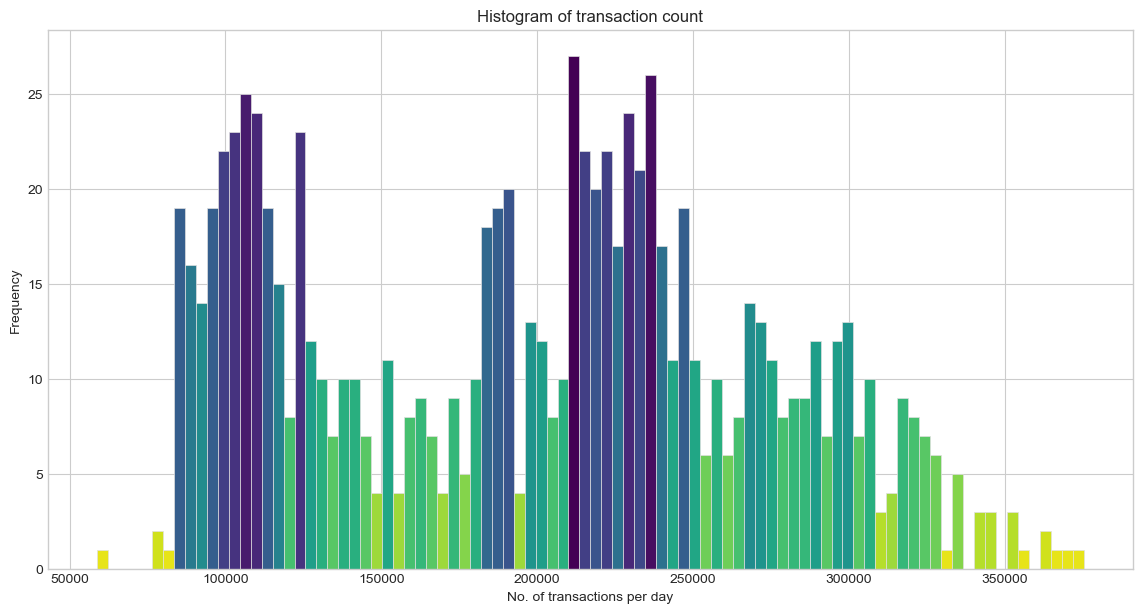

In [4]:
plt.figure(figsize=(14,7))
plt.style.use('seaborn-v0_8-whitegrid')

n, bins, patches = plt.hist(global_data['nb_transactions'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
plt.title('Histogram of transaction count', fontsize=12)
plt.xlabel('No. of transactions per day', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

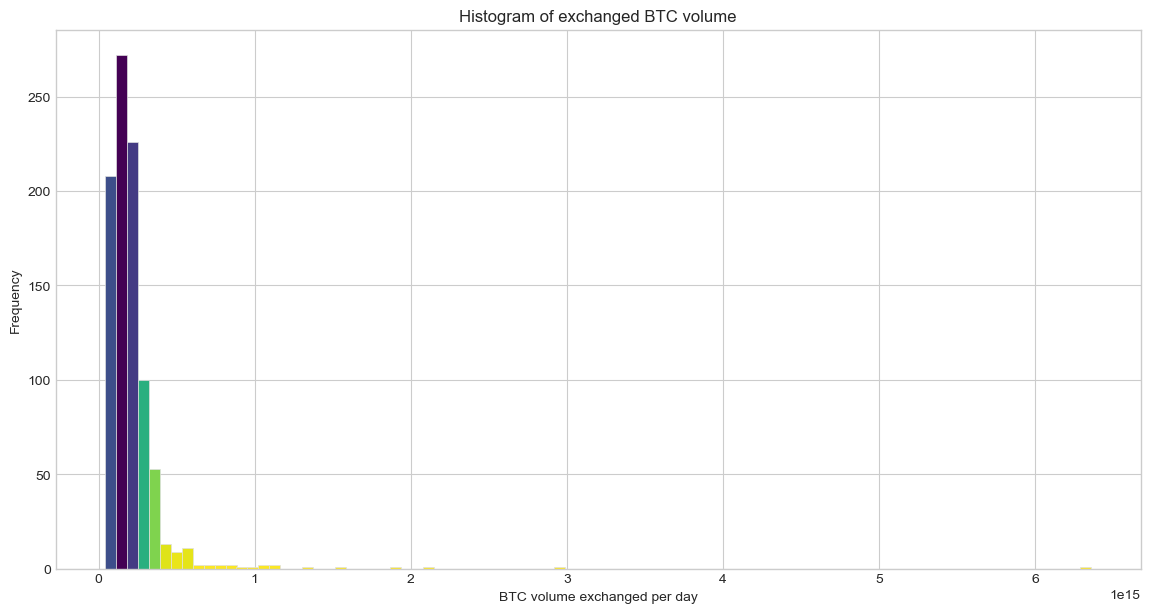

In [5]:
plt.figure(figsize=(14,7))
plt.style.use('seaborn-v0_8-whitegrid')

n, bins, patches = plt.hist(global_data['volume_without_self'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
plt.title('Histogram of exchanged BTC volume', fontsize=12)
plt.xlabel('BTC volume exchanged per day', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

### Auto‑correlation function of BTC volume, price and number of transactions

bla bla bla

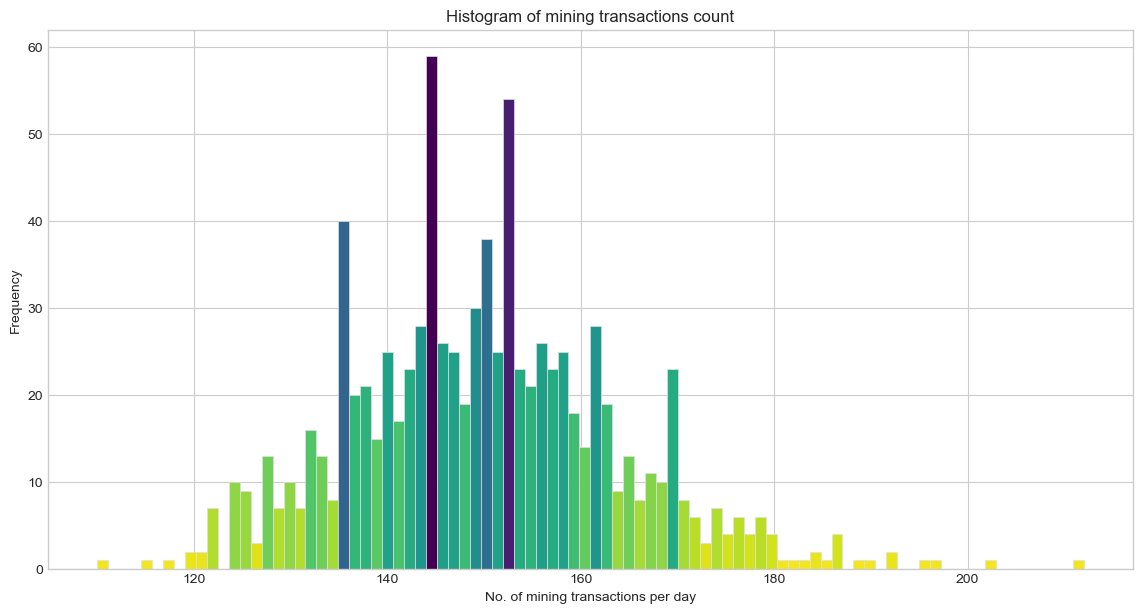

In [6]:
plt.figure(figsize=(14,7))
plt.style.use('seaborn-v0_8-whitegrid')

n, bins, patches = plt.hist(global_data['nb_mining'], bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
plt.title('Histogram of mining transactions count', fontsize=12)
plt.xlabel('No. of mining transactions per day', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

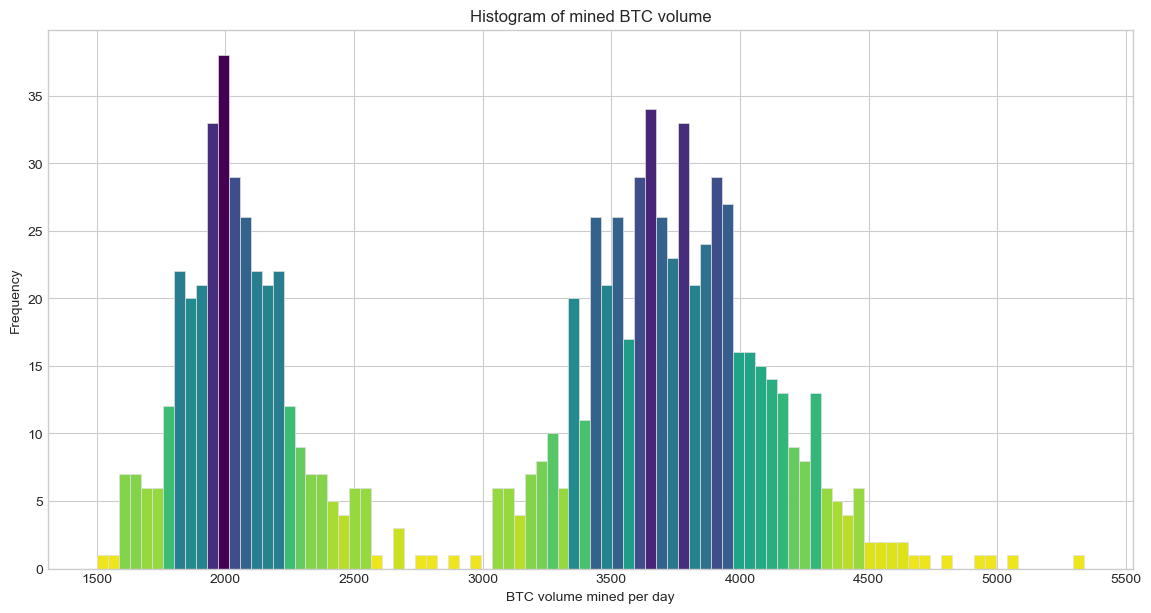

In [7]:
plt.figure(figsize=(14,7))
plt.style.use('seaborn-v0_8-whitegrid')

n, bins, patches = plt.hist(global_data['total_mining_satoshi'] / 100000000, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5)

n = n.astype('int')
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(1 - n[i]/max(n)))
plt.title('Histogram of mined BTC volume', fontsize=12)
plt.xlabel('BTC volume mined per day', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.show()

Text(0.5, 1.0, 'Daily return of BTC volume')

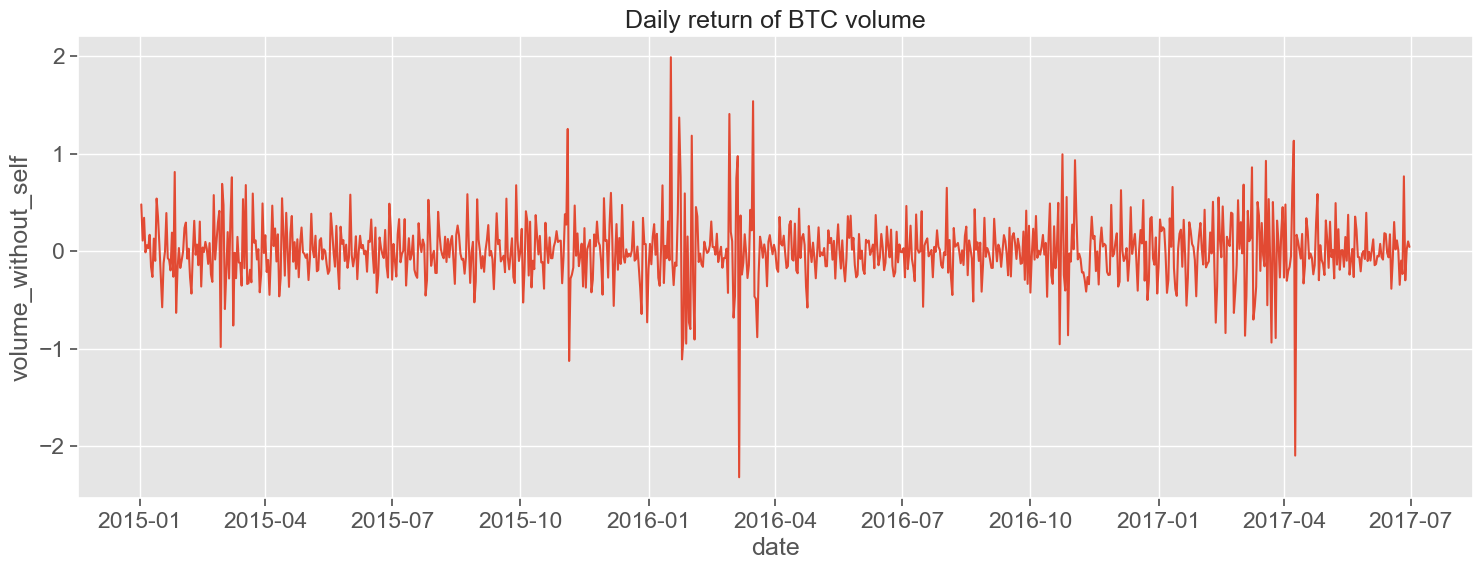

In [12]:
plt.style.use('ggplot')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 1.5})

plt.subplots(figsize=(18, 6))
sns.lineplot(x='date', y=np.log(global_data.volume_without_self).diff(1).shift(0), data=global_data)
plt.title('Daily return of BTC volume')

Text(0.5, 1.0, 'Daily return of # transactions')

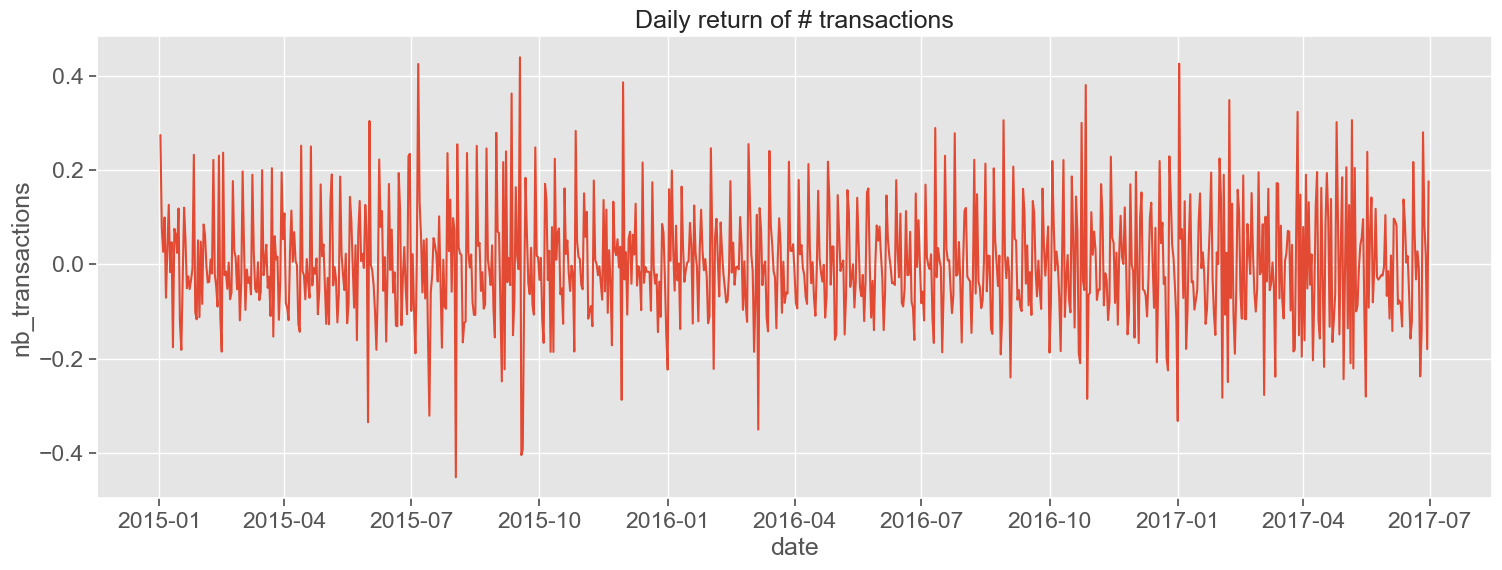

In [15]:
plt.subplots(figsize=(18, 6))
sns.lineplot(x='date', y=np.log(global_data.nb_transactions).diff(1).shift(0), data=global_data)
plt.title('Daily return of # transactions')

Text(0.5, 1.0, 'Daily return of bitcoin price')

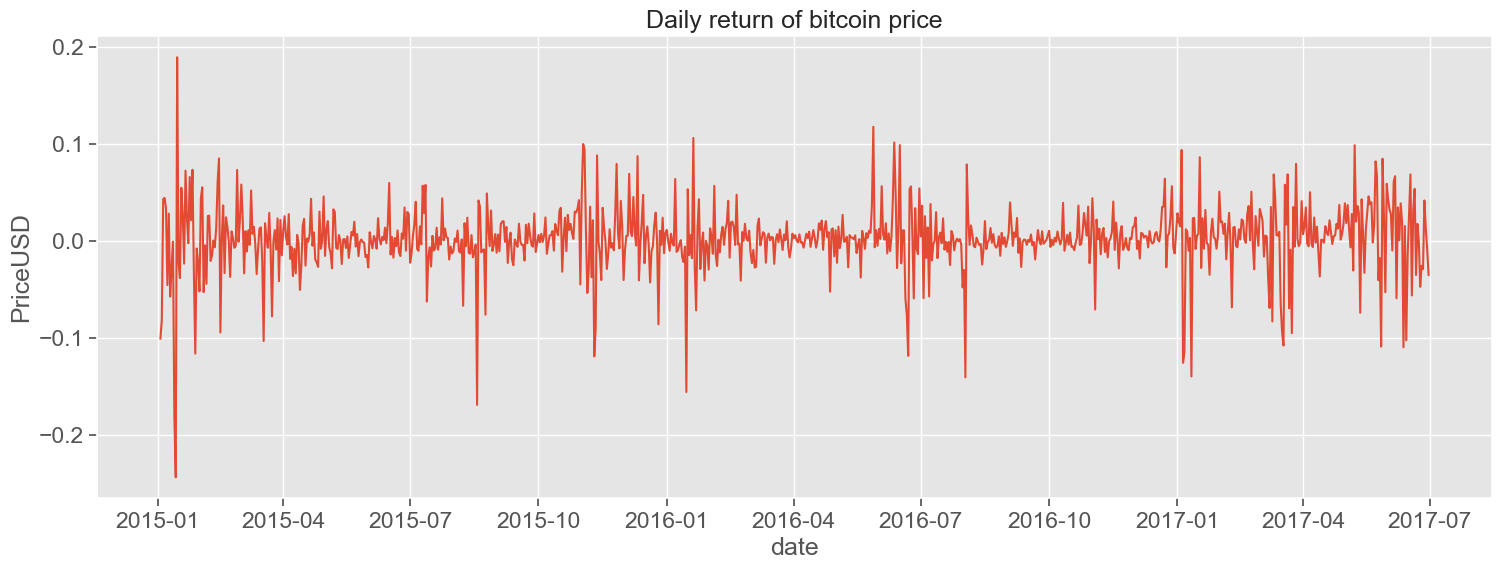

In [25]:
# load bitcoin price data
external_data = pd.read_csv('egc2024/timeseries/external.csv')
# drop first column
external_data.drop(columns=external_data.columns[0], axis=1, inplace=True)
# convert date type
external_data.date = pd.to_datetime(external_data.date)

# calculate the log returns of the bitcoin price
plt.subplots(figsize=(18, 6))
sns.lineplot(x='date', y=np.log(external_data.PriceUSD).diff(1).shift(0), data=external_data)
plt.title('Daily return of bitcoin price')

The Autocorrelation plot for the data is:


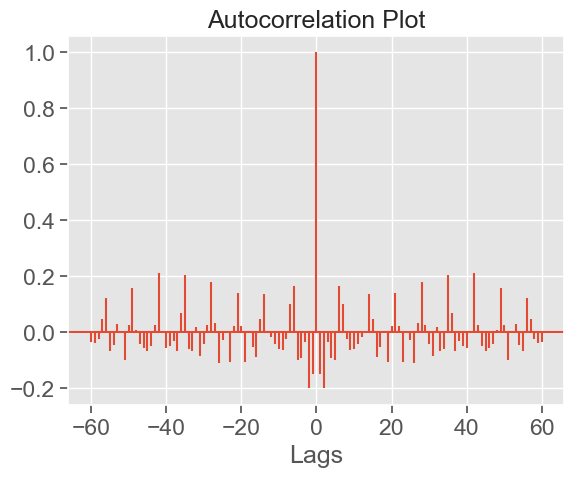

In [39]:
data = np.log(global_data.volume_without_self).diff(1).shift(0).to_numpy()
data[0] = 0
# Data for which we plot Autocorrelation.

# Adding plot title.
plt.title("Autocorrelation Plot")
 
# Providing x-axis name.
plt.xlabel("Lags")
 
# Plotting the Autocorrelation plot.
plt.acorr(data, maxlags = 60, usevlines= True)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()